**420-A52-SF - Algorithmes d'apprentissage supervisé - Automne 2022 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2022 Mikaël Swawola
<br/>
![Travaux Pratiques - Évaluation des modèles de classification](static/13-A1-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif la mise en oeuvre des différentes techniques d'évaluation des modèles de classifications sur des données débalancées

In [36]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%run helpers.py
from sklearn import metrics


<Figure size 640x480 with 0 Axes>

In [2]:
import xgboost as xgb

In [110]:
import sys
!{sys.executable} -m pip install imbalanced-learn
!{sys.executable} -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 2.3 MB/s eta 0:00:00m eta 0:00:010:00:01


### 1 - Simulation de données

In [3]:
from sklearn.datasets import make_moons
from imblearn.datasets import make_imbalance

import pandas as pd
import numpy as np
#from sklearn.datasets import 

In [4]:
N = 10000
ratio_debalancement = 0.01

X_raw, y_raw = make_moons(n_samples=10*N, shuffle=True, noise=0.3, random_state=2020)
X, y =  make_imbalance(X_raw, y_raw, sampling_strategy={0: int(N*(1-ratio_debalancement)), 1: int(N*(ratio_debalancement))})

#### Affichage du jeu de données simulé (classes balancées)

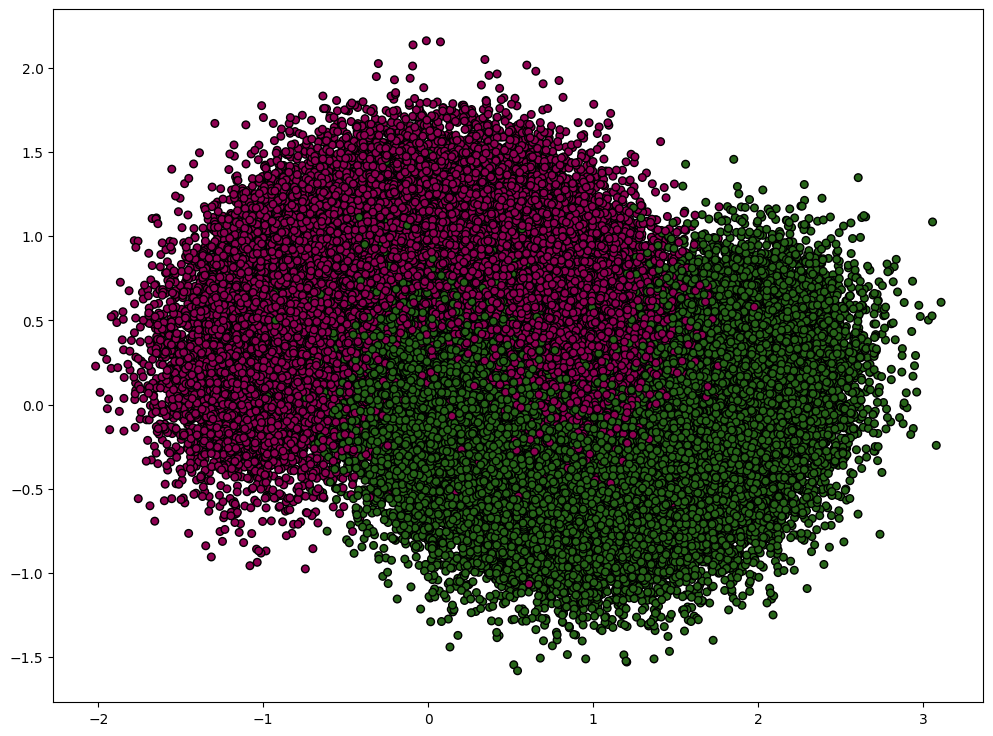

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y_raw, cmap='PiYG', edgecolor='k', s=30)
plt.show()

#### Affichage du jeu de données simulé (classes fortement débalancées)

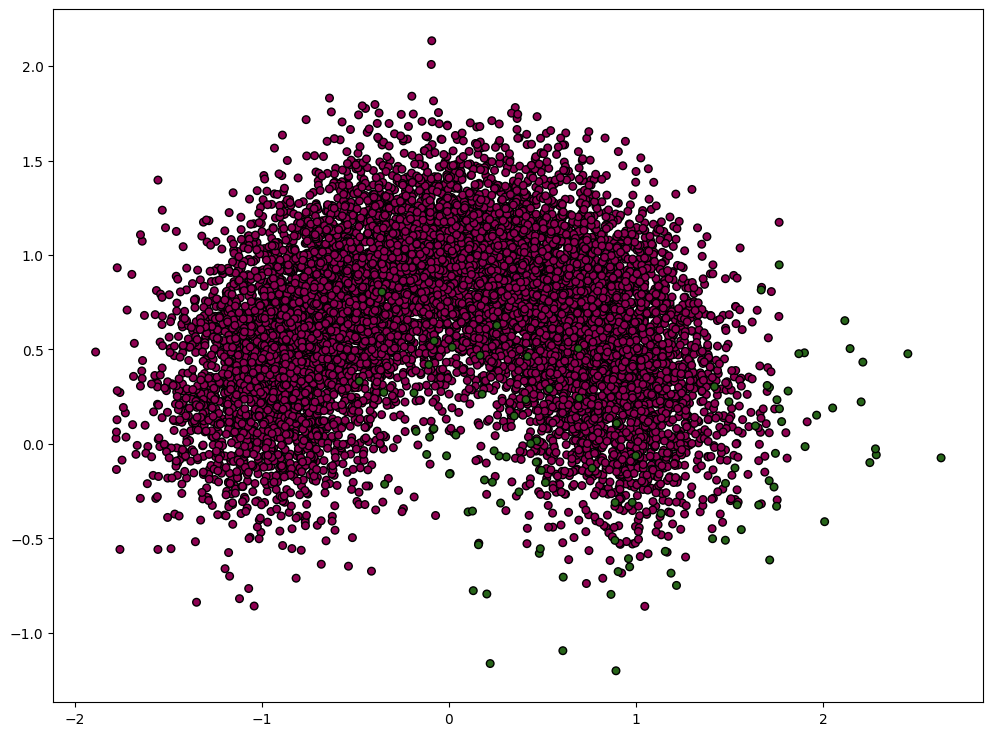

In [6]:
fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PiYG', edgecolor='k', s=30)
plt.show()

### 2 - Préparation de données

<strong>
Séparation des données en train (40%), validation (30%) et test (30%)
</strong>

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_t1, y_train, y_t1 = train_test_split(X, y, train_size=0.4, random_state=2020, stratify=y)


In [19]:
print(X_t1.shape)
print(y_t1.shape)

(6000, 2)
(6000,)


In [21]:

X_val, X_test, y_val, y_test = train_test_split(X_t1, y_t1, test_size=0.5, random_state=2020, stratify=y_t1)

In [22]:
print(X.shape[0])
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

10000
(4000, 2)
(3000, 2)
(3000, 2)


### 3 - Modèle de référence (baseline)

#### Création d'un modèle baseline et calcul de sa précision (accuracy)

In [23]:
from sklearn.dummy import DummyClassifier
baseline_clf = DummyClassifier(strategy = 'most_frequent')
baseline_clf.fit(X_train, y_train)
baseline_clf.score(X_train, y_train)

0.99

### 4 - Entraînement d'un classificateur (régression logistique, ordre 3)

#### Entraînement du modèle et choix du paramètre de régularisation

In [24]:
from sklearn.preprocessing import StandardScaler
### retroune un dataframe standardisé 
def get_scaled_df(pDf, pScaler = StandardScaler()):
    #std = StandardScaler()    
    #return pd.DataFrame(pScaler.fit_transform(pDf), columns = pDf.columns)
    return pd.DataFrame(pScaler.fit_transform(pDf))

In [25]:
### affiche les metriques
def print_metrics(pYtest, pYpred, nbDecimal=3 ):
    print('Mean Absolute Error - [MAE]:', round(metrics.mean_absolute_error(pYtest, pYpred), nbDecimal) )  
    print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(pYtest, pYpred),nbDecimal ) )  
    print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(pYtest, pYpred)),nbDecimal) )
    

In [29]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


# ## regression logistique - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn/notebook
def analyze_logistic(pDfX, pDfY, pCv=5, pMaxIter=1000, pScaler=StandardScaler()):
    X_train, X_test, y_train, y_test = train_test_split(get_scaled_df(pDfX)
                                                        ,pDfY
                                                        , shuffle=True
                                                        , test_size=0.20
                                                        , random_state=2020)
    ## ovr = one versus rest
    lm = LogisticRegressionCV(multi_class = 'ovr', fit_intercept=True, cv=pCv, max_iter=pMaxIter)
    lm.fit(get_scaled_df(X_train), y_train)

    y_pred = lm.predict(X_test)
    print(y_pred)

    print_metrics(y_test, y_pred)
    
    print ("Train - Accuracy [score]: ", lm.score(X_train, y_train))
    print ("Test - Accuracy [score]: ", lm.score(X_test, y_test))
    

In [30]:
analyze_logistic(X_raw, y_raw)

[1 1 1 ... 1 1 1]
Mean Absolute Error - [MAE]: 0.147
Mean Squared Error - [MSE]: 0.147
Root Mean Squared Error - [RMSE]: 0.383
Train - Accuracy [score]:  0.8532375
Test - Accuracy [score]:  0.85335


In [58]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

model = LogisticRegression()
model.fit(X_train_poly, y_train)


accuracy = model.score(X_val_poly, y_val)
accuracy_test = model.score(X_test_poly, y_test)

print("accuracy: ", accuracy)
print("accuracy_test: ", accuracy_test)

#print(model.score(X_train, y_train))
#print(model.score(X_test, y_test))

#logreg=None

accuracy:  0.992
accuracy_test:  0.9913333333333333


In [64]:
X_train_poly.shape

(5714, 10)

#### Affichage de la frontière de décision

([], [])

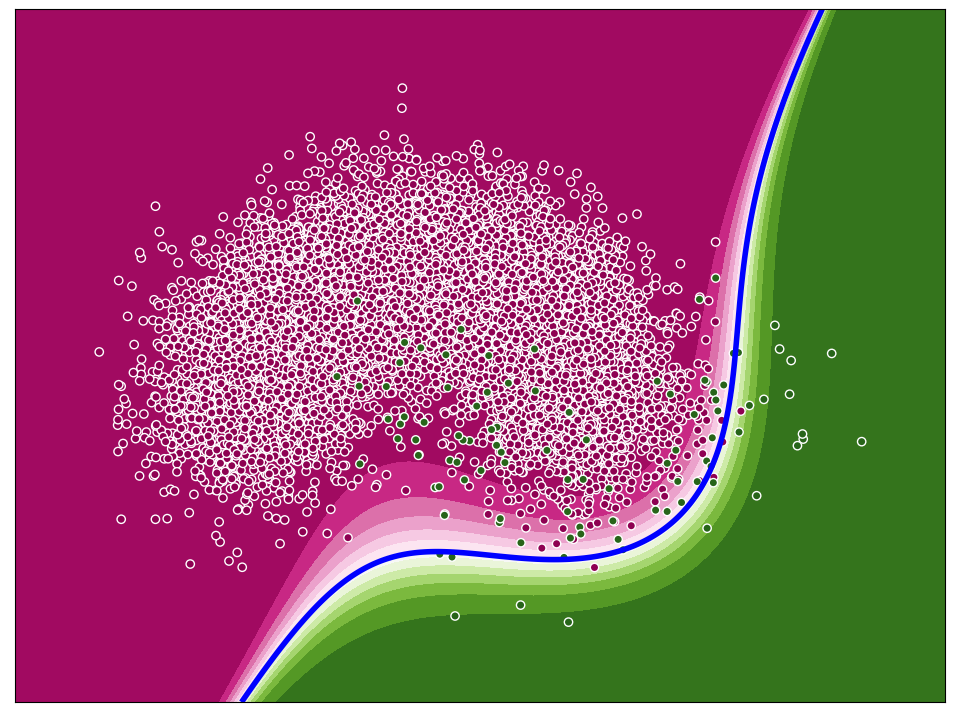

In [59]:
import numpy as np

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

CC = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_proba(poly.fit_transform(CC))[:,1].reshape(xx.shape)

fig = plt.figure(2, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [0.5], colors=["b"], linewidths=[4])

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='w', cmap='PiYG', linewidth=1)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

### 5 - Matrice de confusion sur l'ensemble de validation

#### Affichage de la matrice de confusion pour un seuil de classification rigide de 0.5. Utiliser le fichiers helpers.py

Confusion matrix, without normalization


0.9903333333333333

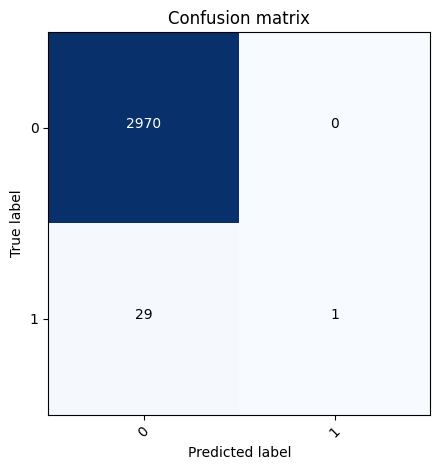

In [91]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from helpers import plot_confusion_matrix as hlp

threshold = 0.5
#threshold = 0.015
## probabilidade entre 0 e 1
#y_val_pred_proba = model.predict_proba(X_val_poly)[:, 1]

model = LogisticRegression()
model.fit(X_train, y_train)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

## 0 ou 1
y_val_pred_label = y_val_pred_proba > threshold ## rigidification

y_val_pred_label=y_val_pred_label

conf = confusion_matrix(y_val, y_val_pred_label)
conf
plot_confusion_matrix(conf, classes=['0', '1'])

accuracy_score(y_val, y_val_pred_label)
#y_pred = model.predict(X_test_poly)
#matrix = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(matrix, classes=(0,1), normalize=False, cmap=plt.cm.Greens)
#print(matrix)
#print(classification_report(y_test, y_pred))
#print(accuracy_score(y_test, y_pred))



In [92]:
accuracy_score(y_val, y_val_pred_label)

0.9903333333333333

#### Calcul de la précision sur l'ensemble de validation

In [78]:
accuracy_score(y_val, y_val_pred_label)

0.8703333333333333

### 6 - Courbe ROC et l'AUC

In [85]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred_proba)

In [94]:
tpr.shape

(52,)

In [93]:
print(np.round(tpr, 3))
print(np.round(fpr,3))
print(np.round(thresholds, 3))

[0.    0.033 0.167 0.167 0.2   0.2   0.233 0.233 0.267 0.267 0.3   0.3
 0.333 0.333 0.367 0.367 0.4   0.4   0.433 0.433 0.5   0.5   0.533 0.533
 0.567 0.567 0.6   0.6   0.633 0.633 0.667 0.667 0.7   0.7   0.733 0.733
 0.767 0.767 0.8   0.8   0.833 0.833 0.867 0.867 0.9   0.9   0.933 0.933
 0.967 0.967 1.    1.   ]
[0.    0.    0.    0.001 0.001 0.001 0.001 0.002 0.002 0.005 0.005 0.007
 0.007 0.014 0.014 0.015 0.015 0.016 0.016 0.016 0.016 0.03  0.03  0.035
 0.035 0.037 0.037 0.061 0.061 0.066 0.066 0.067 0.067 0.092 0.092 0.103
 0.103 0.104 0.104 0.12  0.12  0.166 0.166 0.176 0.176 0.206 0.206 0.232
 0.232 0.366 0.366 1.   ]
[1.559 0.559 0.325 0.273 0.249 0.243 0.239 0.227 0.216 0.185 0.182 0.169
 0.168 0.111 0.11  0.106 0.106 0.1   0.099 0.099 0.098 0.074 0.074 0.065
 0.064 0.062 0.062 0.038 0.038 0.034 0.034 0.033 0.033 0.024 0.024 0.021
 0.021 0.021 0.021 0.017 0.017 0.011 0.01  0.01  0.01  0.007 0.007 0.006
 0.006 0.003 0.003 0.   ]


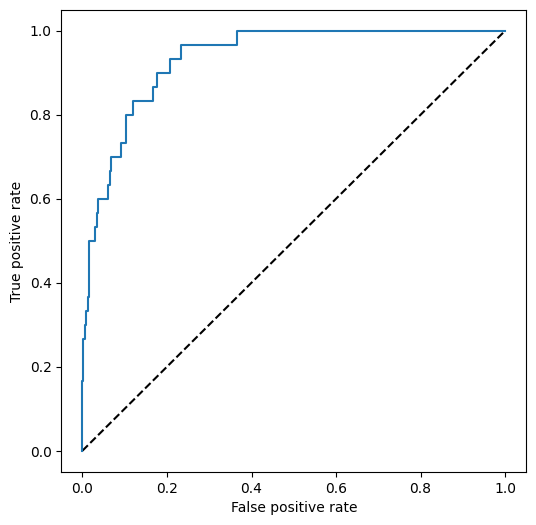

In [95]:
from sklearn.metrics import  roc_curve, roc_auc_score
#fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_label)
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)

#print("[fpr]: ", fpr)
#print("[tpr]: ", tpr)

fig = plt.figure(4, figsize=(6,6))
plt.plot([0,1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
#plot_roc_curve(fpr, tpr)
plt.show()

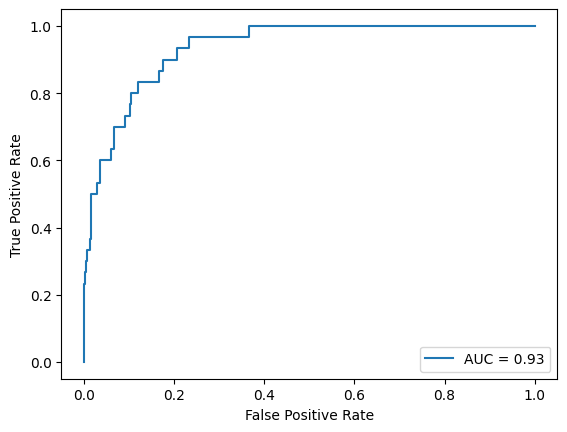

In [96]:
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,)
roc_display.plot()

In [81]:
#print("[fpr]: ", fpr)
#print("[tpr]: ", tpr)
len(fpr)

3

In [90]:
len(thresholds)

52

#### Calcul de la précision sur l'ensemble de validation

In [97]:
print (roc_auc_score(y_val, y_val_pred_proba))

0.9347699214365881


#### Sélection de la meilleur valeur du seuil

In [103]:
## gabarito
## argmax = index of max val
idxMaxVal = np.argmax(tpr - fpr)

print("idxMaxVal = ", idxMaxVal)

print(thresholds[np.argmax(tpr - fpr)])

## valor do melhor threshold
selected_threshold=thresholds[idxMaxVal]

idxMaxVal =  48
0.005819663865856028


Confusion matrix, without normalization


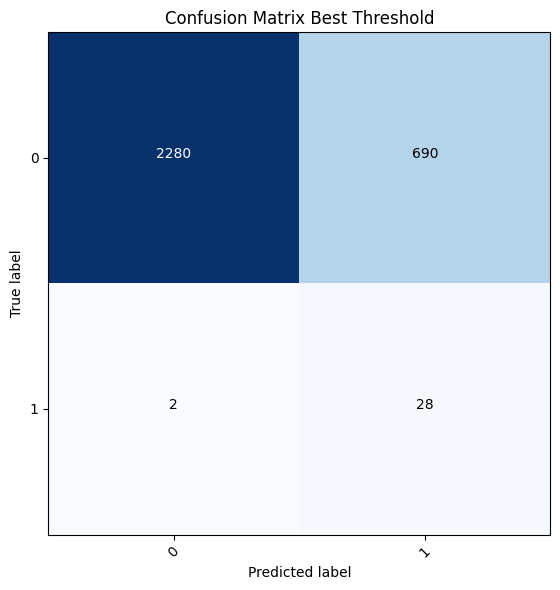

In [105]:
y_val_pred_label = y_val_pred_proba > selected_threshold

fig = plt.figure(6, figsize=(6,6))
cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0', '1'], title='Confusion Matrix Best Threshold')

#### Affichage de la frontière de décision

([], [])

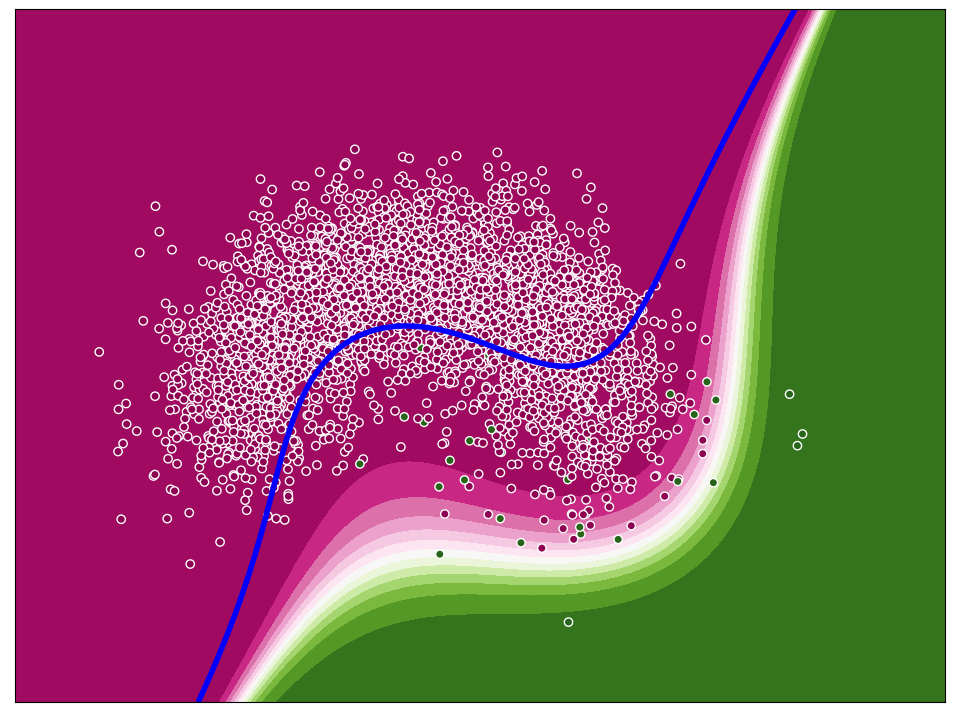

In [106]:
fig = plt.figure(5, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [selected_threshold], colors=["b"], linewidths=[4])

plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, edgecolors='w', cmap='PiYG', linewidth=1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

### 7 -  Calculer la courbe de précision/rappel

#### Affichage de la courbe de précision et rappel

Text(0.5, 1.0, 'Precision-Recall curve')

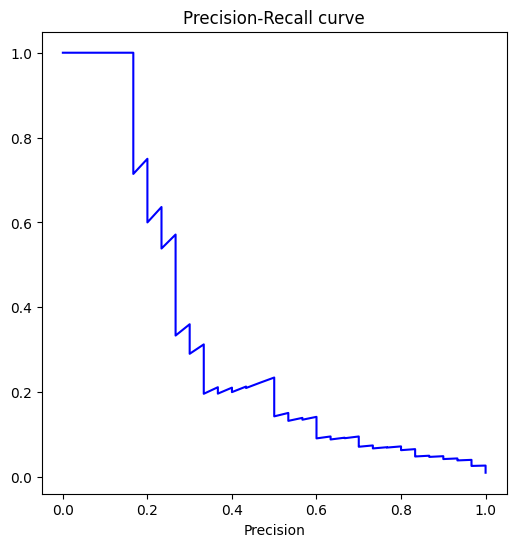

In [109]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_proba)
fig = plt.figure(7, figsize=(6,6))

plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.xlabel('Precision')
plt.title('Precision-Recall curve')


Confusion matrix, without normalization


0.7693333333333333

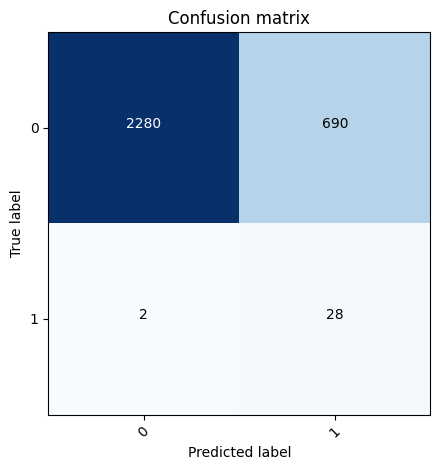

In [102]:
threshold = selected_threshold
pred = model.predict_proba(X_val)[:, 1]
label = pred > threshold
y_val_pred_label=label

conf = confusion_matrix(y_val, label)
conf
plot_confusion_matrix(conf, classes=['0', '1'])

accuracy_score(y_val, label)
#y_pred = model.predict(X_test_poly)
#matrix = confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(matrix, classes=(0,1), normalize=False, cmap=plt.cm.Greens)
#print(matrix)
#print(classification_report(y_test, y_pred))
#print(accuracy_score(y_test, y_pred))


### 8 - Évaluer le F-score pour différents seuils

#### Sélection d'une valeur de beta et calcul du F-score pour différentes valeurs du seuil

In [133]:
from sklearn.metrics import fbeta_score
beta = 2
M = 100
thresholds= np.linspace(-0.1, 1.1, M)

score = np.zeros(shape=(M, ))
for i in range(0, len(thresholds)):
    y_pred_ = (y_val_pred_proba > thresholds[i])*1.0
    score[i] = fbeta_score(y_val, y_pred_, beta=beta)



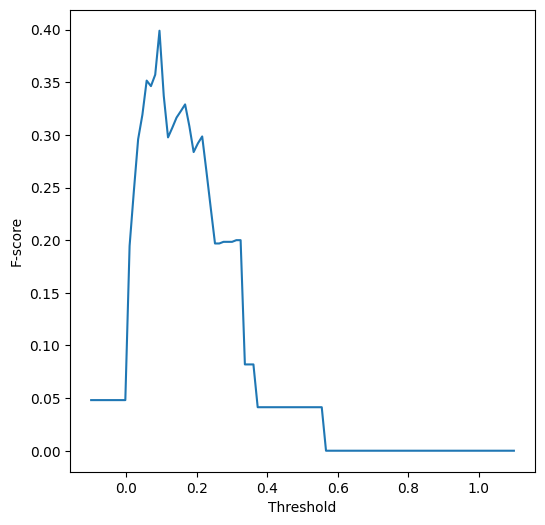

In [134]:
fig = plt.figure(8, figsize=(6,6))
plt.plot(thresholds, score)
plt.xlabel('Threshold')
plt.ylabel('F-score')
plt.show()

In [135]:
score

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.19, 0.25,
       0.3 , 0.32, 0.35, 0.35, 0.36, 0.4 , 0.34, 0.3 , 0.31, 0.32, 0.32,
       0.33, 0.31, 0.28, 0.29, 0.3 , 0.27, 0.23, 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.2 , 0.2 , 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

### 9 - Calcul de la métrique d'entropie croisée

#### Calcul de l'entropie croiseé (ou log loss)

In [132]:
selected_threshold = thresholds[np.argmax(score)]
print(selected_threshold)

0.31212121212121213


### 10 - Calcul de la métrique d'utilité

#### Calcul de la matrice d'utilité correspondant à la matrice de confusion précédente et avec les coûts suivants

FP: -100
FN: -10000
TP: 1000
TN: 0

### Fin de l'atelier